Imports and paths

In [85]:
import numpy as np
import scipy.ndimage as ndimage
from matplotlib import pyplot as plt

DATA_PATH = "data/cudo1.jpg"

Interpolation function

In [158]:
def map(image, mapping, interpolation):
    if interpolation == "nn":
        mapping = np.rint(mapping).astype(int)
        x = mapping[0]
        y = mapping[1]
        np.clip(x, 0, image.shape[0]-1, x)
        np.clip(y, 0, image.shape[1]-1, y)
        new_img = np.zeros((mapping.shape[1], mapping.shape[2], 3))

        for i in range(3):
            new_img[:,:,i] = image[x, y, i]
        return new_img

    elif interpolation == "bi":
        x,y = np.int32(np.rint(mapping))
        pass

Utilities

In [175]:
def rotate(pts, rds):
    theta = np.radians(rds)
    # Rotation operation:
    # Rv = [xcos(theta) - ysin(theta), xsin(theta) + ycos(theta)]
    r_pts_x = pts[0] * np.cos(theta) - pts[1] * np.sin(theta)
    r_pts_y = pts[0] * np.sin(theta) + pts[1] * np.cos(theta)
    return np.array([r_pts_x, r_pts_y])


def plot_points(pts):
    plt.figure()
    plt.imshow(img)
    plt.plot(pts[1, :], pts[0, :])

Reading data

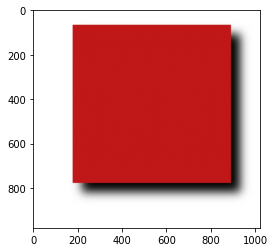

In [127]:
img = plt.imread(DATA_PATH)/255
plt.imshow(img)

Generate picture coordinates used for interpolation

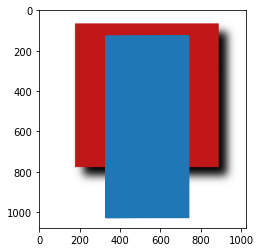

In [200]:
X, Y = np.meshgrid(np.arange(512), np.arange(512))
# Scale and move image
X = X*410/X.shape[0]
Y = Y*900/Y.shape[0]
X += 330
Y += 128
points = np.array((Y.reshape(-1), X.reshape(-1)))
plt.figure()
plt.imshow(img)
plt.plot(points[1, :], points[0, :])

Adapt shape for map processing

In [201]:
mapping = np.array([Y, X])
mapping.shape

(2, 512, 512)

Show interpolated picture using built-in function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


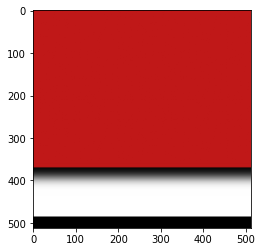

In [202]:
img_tr = np.zeros((X.shape[0], X.shape[1], 3))
img_tr[:, :, 0] = ndimage.interpolation.map_coordinates(img[:, :, 0], mapping)
img_tr[:, :, 1] = ndimage.interpolation.map_coordinates(img[:, :, 1], mapping)
img_tr[:, :, 2] = ndimage.interpolation.map_coordinates(img[:, :, 2], mapping)
plt.figure()
plt.imshow(img_tr)

Preprocess image and set variables

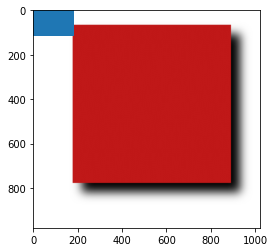

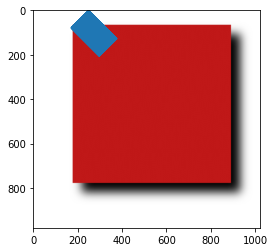

In [234]:
# Set new shape
new_shp = (112, 180)
x, y = np.meshgrid(np.arange(new_shp[0]), np.arange(new_shp[1]))

draw_points = np.array((x.reshape(-1), y.reshape(-1)))
plot_points(draw_points)

# Rotate newly created points
points = np.array([y, x])
points = rotate(points, 45)

# Move mapping
points[0] += 250
points[1] += 0
draw_points = np.array((points[1].reshape(-1), points[0].reshape(-1)))
plot_points(draw_points)

# new_x and new_y represent the indices we need to interpolate
new_x = ((img.shape[0]-1) / (new_shp[0]-1)) * x
new_y = ((img.shape[1]-1) / (new_shp[1]-1)) * y
mapping = np.array([new_y, new_x])


Nearest neighbor interpolate

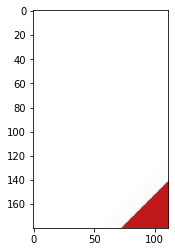

In [232]:
# Nearest neighbor
nn_interpolated = map(img, points, "nn")
plt.figure()
plt.imshow(nn_interpolated)
# new_img = new_img.astype(float)
# plot_points(new_img)


# Bilinear

In [6]:
print("Nearest neighbor interpolation")

Nearest neighbor interpolation
